In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
# -----------------------------
# 1. Load MSNIST dataset
# -----------------------------

# This will stream the data, you don't have to download the full file
# mnist_train = load_dataset("ylecun/mnist", split="train")

# mnist_test = load_dataset("ylecun/mnist", split="test")


##### Look into the normalisation #####
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

mnist_train = datasets.MNIST("./data", train=True, download=False, transform=transform)

mnist_test = datasets.MNIST("./data", train=False, download=False, transform=transform)

In [3]:
img, label = mnist_train[0]
print(img.shape)    # e.g., torch.Size([1, 28, 28])
print(type(label))

torch.Size([1, 28, 28])
<class 'int'>


In [ ]:
def patch(img, patch_size=7):
    # img shape: (1, 28, 28)
    patches = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    # shape: (1, 4, 4, 7, 7)
    patches = patches.contiguous().view(1, -1, patch_size, patch_size)
    # shape: (1, 16, 7, 7)
    return patches.squeeze(0)  # (16, 7, 7)

In [5]:
img, label = mnist_train[0]  # img: (1, 28, 28)
patches = patch(img, patch_size=7)
print(patches.shape)  # Should print: torch.Size([16, 7, 7])

torch.Size([16, 7, 7])


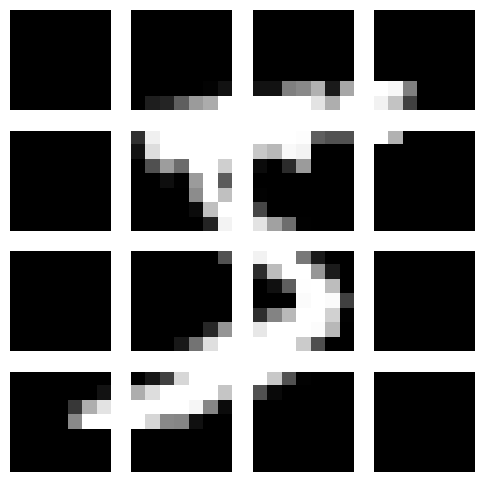

In [6]:
img, _ = mnist_train[0]
patches = patch(img)

fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(patches[i], cmap='gray')
    ax.axis('off')
plt.show()

In [7]:
all_patches = [patch(img) for img, _ in mnist_train]  # list of (16,7,7)
all_patches = torch.stack(all_patches)  # (N, 16, 7, 7)
all_labels = torch.tensor([label for _, label in mnist_train])  # shape: (60000,)


In [8]:
print(all_patches.shape)  # Should print: torch.Size([60000, 16, 7, 7])
print(all_labels.shape)  # Should print: torch.Size([60000])

torch.Size([60000, 16, 7, 7])
torch.Size([60000])


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/IPython/core/completer.py", line 3496, in _complete
    result = matcher(context)
             ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/IPython/core/completer.py", line 2253, in magic_matcher
    global_matches = self.global_matches(bare_text)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/IPython/core/completer.py", line 1132, in global_matches
    for word in lst:
                ^^^
RuntimeError: dictionary changed size during iteration


In [9]:
flat_patches = all_patches.view(60000, 16, -1)  # shape: (60000, 16, 49)
print(flat_patches.shape)  # Should print: torch.Size([60000, 16, 49])

torch.Size([60000, 16, 49])


In [10]:
patch_size = 7
embed_dim = 64
patch_dim = patch_size * patch_size

class PatchEmbed(nn.Module):
    """A simple linear projection of patches to embeddings."""
    def __init__(self, patch_dim, embed_dim):
        super().__init__()
        self.proj = nn.Linear(patch_dim, embed_dim)

    def forward(self, x):
        # x: (B, num_patches, patch_dim)
        return self.proj(x)
    
flat_patch_embed = PatchEmbed(patch_dim, embed_dim)(flat_patches)  # shape: (60000, 16, 64)
print(flat_patch_embed.shape)

torch.Size([60000, 16, 64])


In [11]:
# Create CLS token and concatenate it to the patch embeddings

B, N, D = flat_patch_embed.shape

# Create a learnable CLS token
class_token = nn.Parameter(torch.zeros(1, 1, D))  # (1, 1, 64)
nn.init.trunc_normal_(class_token, std=0.02)  # paper uses truncated normal for init

# Expand CLS token for the batch
cls_tokens = class_token.expand(B, -1, -1)  # (60000, 1, 64)

# Concatenate to the front of the patch embeddings
vit_input = torch.cat([cls_tokens, flat_patch_embed], dim=1)  # (60000, 17, 64)

In [12]:
print(class_token)
print(nn.init.trunc_normal_(class_token, std=0.02))

Parameter containing:
tensor([[[-0.0228,  0.0049, -0.0077, -0.0052,  0.0391, -0.0071,  0.0343,
          -0.0206, -0.0264, -0.0020,  0.0072,  0.0371,  0.0134, -0.0102,
           0.0050,  0.0039, -0.0222,  0.0034,  0.0100, -0.0017, -0.0213,
          -0.0030, -0.0033, -0.0162, -0.0116,  0.0127, -0.0206,  0.0041,
           0.0116,  0.0284, -0.0166, -0.0261, -0.0070, -0.0237,  0.0406,
           0.0195, -0.0050, -0.0240, -0.0132,  0.0047,  0.0005, -0.0016,
          -0.0148, -0.0376, -0.0013, -0.0298,  0.0248,  0.0185,  0.0103,
          -0.0019, -0.0246, -0.0227, -0.0153,  0.0065, -0.0344,  0.0397,
           0.0281, -0.0251,  0.0088,  0.0298, -0.0276,  0.0139, -0.0108,
          -0.0135]]], requires_grad=True)
Parameter containing:
tensor([[[ 1.9910e-02, -1.4961e-02, -3.3216e-02,  2.9911e-03, -2.6402e-02,
          -2.2968e-02, -1.7589e-02, -1.1884e-02,  2.3161e-02,  3.5351e-03,
          -8.5228e-03, -1.0269e-02, -3.0990e-02,  4.8729e-03,  6.8288e-05,
           1.2698e-02,  5.1579e-

In [13]:
# Add positional encoding to the patch embeddings and CLS token

# Create positional embeddings (learnable)
pos_embed = nn.Parameter(torch.zeros(1, N + 1, D))  # (1, 17, 64)
nn.init.trunc_normal_(pos_embed, std=0.02)

# Add positional encoding to vit_input
vit_input = vit_input + pos_embed  # (60000, 17, 64)

In [14]:
print(pos_embed)
print(nn.init.trunc_normal_(pos_embed, std=0.02))

Parameter containing:
tensor([[[ 4.7437e-03, -6.4648e-03,  2.4761e-02,  ..., -7.9734e-02,
          -2.5453e-03,  4.5758e-02],
         [ 7.6552e-04, -2.0545e-02, -3.2624e-03,  ...,  6.9082e-03,
           2.0913e-02,  7.6138e-06],
         [ 2.5296e-02, -1.9518e-05,  2.7421e-02,  ..., -6.0568e-03,
           5.5372e-02, -4.3617e-02],
         ...,
         [-3.6805e-03,  3.0003e-02,  8.8548e-03,  ...,  3.2514e-02,
           3.0161e-03, -6.0853e-03],
         [ 3.0060e-02,  2.4509e-02,  7.3096e-03,  ..., -2.4491e-02,
          -2.4062e-02, -4.6620e-03],
         [ 9.1824e-03, -8.2403e-03, -6.9390e-03,  ...,  2.1619e-02,
          -1.4267e-02,  4.9546e-03]]], requires_grad=True)
Parameter containing:
tensor([[[-0.0031, -0.0267,  0.0136,  ..., -0.0383, -0.0104, -0.0110],
         [ 0.0115,  0.0256,  0.0232,  ...,  0.0074, -0.0241,  0.0085],
         [-0.0166,  0.0074,  0.0122,  ...,  0.0213,  0.0296, -0.0091],
         ...,
         [-0.0058, -0.0204,  0.0176,  ..., -0.0161,  0.0300,  0

In [15]:
class EncoderBlock(nn.Module):
    """Visual Transformer encoder for the MNIST dataset."""
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )

    def forward(self, x):
        """Forward pass of the encoder block."""
        # x shape: (B, N, D) where B is batch size, N is number of patches + 1 (CLS token), D is embedding dimension
        x_res1 = x
        x = self.ln1(x)
        x, _ = self.attn(x, x, x)  # Self-attention
        x = x + x_res1             # Residual connection 1

        x_res2 = x
        x = self.ln2(x)
        x = self.mlp(x)
        x = x + x_res2             # Residual connection 2
        return x
    
class VisualTransformer(nn.Module):
    """Visual Transformer for the MNIST dataset."""
    def __init__(self, embed_dim, num_heads, num_layers, num_classes=10):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(embed_dim, num_heads) for _ in range(num_layers)])
        self.ln = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        """Forward pass of the Visual Transformer."""
        for layer in self.layers:
            x = layer(x)
        x = self.ln(x)
        return self.head(x[:, 0, :])  # Use CLS token for classification

In [16]:
# Example with first 128 images:
B = 128
test_x = vit_input[:B]           # shape: (128, 17, 64)
test_labels = all_labels[:B]     # shape: (128,)

num_heads = 4
num_layers = 3  

model = VisualTransformer(embed_dim=embed_dim, num_heads=num_heads, num_layers=num_layers)

out = model(test_x)              # Should be (128, 10)
print(out.shape)
print(out[0])  # Print the output for the first image

torch.Size([128, 10])
tensor([-0.4947, -0.0908, -0.1558, -0.5772, -0.9769,  0.7581,  0.1659, -0.1473,
        -0.8144, -0.2715], grad_fn=<SelectBackward0>)


In [ ]:
# Training loop with cross entropy loss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

embed_dim = 64
num_heads = 4
num_layers = 3

model = VisualTransformer(embed_dim=embed_dim, num_heads=num_heads, num_layers=num_layers)
model = model.to(device)

# Loop through parameters and set requires_grad to True
for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

dataset = TensorDataset(vit_input, all_labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 10


for i in range(num_epochs):
    correct_total, sample_total = 0, 0
    model.train()
    for x_batch, y_batch in tqdm(dataloader, desc="Training", total=len(dataloader)):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        logits = model(x_batch)
        loss = loss_fn(logits, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = logits.argmax(dim=1)  # (B,)
        correct_preds = (preds == y_batch).sum().item()
        sample_total += len(y_batch)
        correct_total += correct_preds

    epoch_accuracy = (correct_total / sample_total) *100
    print(f"Epoch {i+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {epoch_accuracy:.2f}")

torch.save(staticmethod(model.state_dict()), "mnist_vit_encoder.pth")

Training: 100%|██████████| 1875/1875 [01:06<00:00, 27.99it/s]


Epoch 1/10, Loss: 0.4274, Accuracy: 80.9100


Training: 100%|██████████| 1875/1875 [01:34<00:00, 19.85it/s]


Epoch 2/10, Loss: 0.2263, Accuracy: 90.9433


Training: 100%|██████████| 1875/1875 [02:52<00:00, 10.89it/s]


Epoch 3/10, Loss: 0.2976, Accuracy: 93.2117


Training:  59%|█████▊    | 1097/1875 [03:35<01:17, 10.03it/s]